In [ ]:
!pip install -q ultralytics opencv-python-headless 
!git clone https://github.com/aras62/PIE.git
!unzip /content/PIE/annotations/annotations.zip -d /content/PIE
!unzip /content/PIE/annotations/annotations_vehicle.zip -d /content/PIE
!mkdir /kaggle/working/PIE/content
!git clone https://github.com/hustvl/YOLOP.git

In [2]:
import os
import cv2
import torch
import numpy as np
import xml.etree.ElementTree as ET
from tqdm.notebook import tqdm # Use notebook version if in Kaggle notebook
# from tqdm import tqdm # Use standard if running as .py script
import pickle # To save the processed data easily
import zipfile

In [ ]:
zip_path = "/kaggle/working/PIE/annotations/annotations.zip"
extract_to = "/kaggle/working/PIE/annotations/"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

In [3]:
# ================================================================
# YOLOP-only feature extractor
# ================================================================
import importlib
import subprocess
import sys
import os
import gc
import time
import zipfile
import warnings
import cv2
import numpy as np
import torch
import xml.etree.ElementTree as ET
from tqdm.auto import tqdm
import pickle 


# ---------- auto-install tiny deps ----------
def _ensure(pkg):
    try:
        importlib.import_module(pkg)
    except ModuleNotFoundError:
        warnings.warn(f"Installing {pkg} …")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])

# Ensure YOLOP dependencies (yacs might be needed for config)
for _p in ("prefetch_generator", "yacs"):
    _ensure(_p)

# ---------- paths & config ----------
BASE_VIDEO_INPUT_DIR = "/kaggle/input"
BASE_ANNOTATION_DIR  = "/kaggle/working/PIE/annotations/annotations"
SETS_TO_PROCESS      = ["set04"]        

YOLOP_ROOT           = "/kaggle/working/YOLOP" # Root of the cloned YOLOP repo
YOLOP_IMG_SIZE       = 640
CONF_THRES, IOU_THRES= 0.25, 0.45 # NMS thresholds

GRID_SIZE            = 3 # Example: 3x3 grid
GRID_SCALE           = 1.0 # Cell size relative to pedestrian height
RADIUS_M             = 15.0 # Radius for nearby object count
PIX_PER_M            = 30 # Rough estimate, adjust per dataset/camera if possible
TOTAL_DIM            = GRID_SIZE**2 * 2 + 2   # = 20 (9 for DA + 9 for LL + 2 for counts)

OUTPUT_PKL_DIR       = "/kaggle/working/extracted_yolop_only"
OUTPUT_ZIP_FILE      = "/kaggle/working/all_video_yolop.zip"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.makedirs(OUTPUT_PKL_DIR, exist_ok=True)

print("–– YOLOP-only extraction ––")
print("Device:", DEVICE, "\n")

# ---------- add YOLOP repo to path and import necessary modules ---
if YOLOP_ROOT not in sys.path:
    sys.path.insert(0, YOLOP_ROOT)
try:
    # Assuming standard YOLOP repo structure and necessary imports
    from lib.config import cfg # YOLOP usually uses yacs for config
    from lib.config import update_config
    from lib.models import get_net # Function to build the YOLOP model
    from lib.core.general import non_max_suppression, scale_coords
    from lib.utils.utils import select_device, letterbox # YOLOP's letterbox might differ slightly
    from lib.utils import plots
except ImportError as e:
    print(f"Error importing from YOLOP repository at {YOLOP_ROOT}")
    print("Please ensure the YOLOP repository is cloned correctly and the path is set.")
    print(f"ImportError: {e}")
    exit()
# -----------------------------------------------------------------

# ---------- helper fns ----------
# Use YOLOP's letterbox if available, otherwise use the one defined here
# Make sure the logic matches what was used during YOLOP training if possible
try:
    from lib.utils.utils import letterbox as yolop_letterbox
    print("Using letterbox function from YOLOP library.")
except ImportError:
    print("YOLOP letterbox not found, using local definition.")
    def yolop_letterbox(img, new_shape=YOLOP_IMG_SIZE, color=(114, 114, 114), auto=False, scaleFill=False, scaleup=True):
        # Resize image to a 32-pixel-multiple rectangle https://github.com/ultralytics/yolov3/issues/232
        shape = img.shape[:2]  # current shape [height, width]
        if isinstance(new_shape, int):
            new_shape = (new_shape, new_shape)

        # Scale ratio (new / old)
        r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
        if not scaleup:  # only scale down, do not scale up (for better test mAP)
            r = min(r, 1.0)

        # Compute padding
        ratio = r, r  # width, height ratios
        new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
        dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
        if auto:  # minimum rectangle
            dw, dh = np.mod(dw, 32), np.mod(dh, 32)  # wh padding
        elif scaleFill:  # stretch
            dw, dh = 0.0, 0.0
            new_unpad = (new_shape[1], new_shape[0])
            ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios

        dw /= 2  # divide padding into 2 sides
        dh /= 2

        if shape[::-1] != new_unpad:  # resize
            img = cv2.resize(img, new_unpad, interpolation=cv2.INTER_LINEAR)
        top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
        left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
        img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
        # Return img, ratio, padding
        return img, ratio, (dw, dh)

def parse_annotations(xml_path):
    try:
        root = ET.parse(xml_path).getroot()
    except Exception as e:
        print(f"XML error parsing {os.path.basename(xml_path)}: {e}")
        return {}, [], (None, None)
    sz = root.find(".//original_size")
    wh = (int(sz.find("width").text), int(sz.find("height").text)) if (sz is not None and sz.find("width") is not None and sz.find("height") is not None) else (None, None)

    by_frame = {}
    frames = set()
    # Iterate through all tracks, not just pedestrians initially if needed elsewhere, but filter here
    for track in root.findall(".//track"):
        if track.get("label", "").lower() not in {"pedestrian"}: # Filter for pedestrians only
            continue

        # Try getting ID from track first, then from box attribute
        pid = track.get("id")
        if pid is None:
             first_box = track.find('./box')
             if first_box is not None:
                 id_elem = first_box.find('./attribute[@name="id"]')
                 if id_elem is not None:
                     pid = id_elem.text
        if pid is None:
             # print(f"Warning: Skipping track without ID in {os.path.basename(xml_path)}")
             continue

        for box in track.findall("./box"):
            if box.get("outside") == "1":
                continue
            try:
                # PIE frames are 1-based in annotations
                f = int(box.get("frame"))
                bb = [float(box.get(k)) for k in ("xtl", "ytl", "xbr", "ybr")]
                # Ensure bounding box is valid (x1 < x2, y1 < y2)
                if bb[0] >= bb[2] or bb[1] >= bb[3]:
                    # print(f"Warning: Invalid bbox {bb} for P:{pid} F:{f} in {os.path.basename(xml_path)}")
                    continue
                by_frame.setdefault(f, {})[pid] = {"bbox_pixels": bb}
                frames.add(f)
            except (TypeError, ValueError, AttributeError) as e:
                 print(f"Warning: Error parsing box attrs for P:{pid} F:{box.get('frame')} in {os.path.basename(xml_path)}: {e}")
                 continue # Skip malformed box
    return by_frame, sorted(list(frames)), wh

def grid_feats(mask, cx, cy, h_pix, g=GRID_SIZE, scale=GRID_SCALE):
    if mask is None or h_pix <= 0:
        return np.zeros(g * g, dtype=np.float32) # Corrected dtype
    cell = max(1, int(h_pix * scale))
    half = (g * cell) // 2
    H, W = mask.shape[:2]
    out = np.zeros((g, g), dtype=np.float32) # Corrected dtype
    cx, cy = int(cx), int(cy) # Ensure center points are integers
    for r in range(g):
        for c in range(g):
            x1 = int(np.clip(cx - half + c * cell, 0, W))
            y1 = int(np.clip(cy - half + r * cell, 0, H))
            x2 = int(np.clip(x1 + cell, 0, W))
            y2 = int(np.clip(y1 + cell, 0, H))
            if x2 > x1 and y2 > y1:
                # Assuming mask values are 0 or 255 after sigmoid+interpolation
                mean_val = mask[y1:y2, x1:x2].mean()
                out[r, c] = mean_val / 255.0 if mean_val > 0 else 0.0 # Normalize
    return out.reshape(-1)

def nearby_counts(det, cx, cy, r_pix):
    if det is None or not isinstance(det, np.ndarray) or det.shape[0] == 0: # Added type check
        return np.zeros(2, dtype=np.float32) # Corrected dtype
    veh_cls = {2, 3, 5, 7}; ped_cls = 0 # COCO IDs
    veh = ped = 0
    for i in range(det.shape[0]): # Iterate through rows
        box = det[i, :4] # First 4 elements are bbox
        cls = det[i, 5] # 6th element is class
        bx, by = (box[0] + box[2]) / 2, (box[1] + box[3]) / 2
        # Ensure distances are calculated with floats before comparing squares
        if (float(bx) - float(cx)) ** 2 + (float(by) - float(cy)) ** 2 < float(r_pix) ** 2:
            if int(cls) in veh_cls:
                veh += 1
            elif int(cls) == ped_cls:
                # Simple count, might include the pedestrian itself if detected
                ped += 1
    m = 10.0 # Max count for normalization
    return np.array([min(veh, m) / m, min(ped, m) / m], dtype=np.float32) # Corrected dtype

# ---------- load YOLOP ----------
print("Loading YOLOP …")
try:
    # --- Load model using YOLOP's intended mechanism ---
    # Define dummy args or load from a config file if needed by get_net
    # This typically involves setting up the configuration first
    # Example: Assuming a default config file exists in YOLOP repo
    cfg_path = os.path.join(YOLOP_ROOT, 'lib', 'config', 'default.py') # Adjust if needed
    # update_config(cfg, args) # Update cfg based on command line args or defaults

    yolop_model = get_net(cfg) # Build model based on config
    # Load pretrained weights
    # Use the official YOLOP checkpoint path if available
    checkpoint_path = os.path.join(YOLOP_ROOT, 'weights', 'yolop.pth') # Example path
    if not os.path.exists(checkpoint_path):
        # Try the path you provided if the default doesn't exist
        checkpoint_path = '/kaggle/input/yolop-weights/pytorch/default/1/End-to-end.pth' # Replace with actual input path
        if not os.path.exists(checkpoint_path):
            raise FileNotFoundError("YOLOP pretrained weights not found at default or specified path.")

    checkpoint = torch.load(checkpoint_path, map_location=DEVICE)

    # Load the state dict, handle potential mismatches if necessary
    # Check if weights are nested under 'state_dict' or similar key
    state_dict = checkpoint.get('state_dict', checkpoint)
    # Adapt state dict keys if needed (e.g., remove 'module.' prefix if saved from DataParallel)
    adapted_state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}

    yolop_model.load_state_dict(adapted_state_dict, strict=False) # Use strict=False initially
    print("YOLOP weights loaded.")

    yolop_model.to(DEVICE)
    yolop_model.eval()
    # --- End YOLOP model loading ---
except Exception as e:
    print(f"\nFATAL ERROR loading YOLOP model: {e}")
    print("Check YOLOP_ROOT path and model loading logic.")
    exit()


# ---------- main loop ----------
pkls = []
total_start_time = time.time()

for set_id in tqdm(SETS_TO_PROCESS, desc="Sets"):
    print(f"\n--- Processing Set: {set_id} ---")
    annotation_set_dir = os.path.join(BASE_ANNOTATION_DIR, set_id)
    video_set_input_dir_name = f"pie-{set_id}"
    video_set_input_path = os.path.join(BASE_VIDEO_INPUT_DIR, video_set_input_dir_name)

    if not os.path.isdir(annotation_set_dir) or not os.path.isdir(video_set_input_path):
        print(f"Warning: Annotation or Video Input directory not found for {set_id}. Skipping set.")
        continue

    try:
        xml_files = sorted([f for f in os.listdir(annotation_set_dir) if f.endswith('_annt.xml')])
        if not xml_files: continue
    except Exception as e: print(f"Error listing annotations for {set_id}: {e}"); continue
    print(f"Found {len(xml_files)} annotation files in {set_id}.")

    for xml_filename in tqdm(xml_files, desc=f"Videos in {set_id}", leave=False):
        video_id = xml_filename.replace('_annt.xml', '')
        video_start_time = time.time()
        print(f"\n  Processing Video: {video_id} (Set: {set_id})...")

        annotation_xml_path = os.path.join(annotation_set_dir, xml_filename)
        video_path = os.path.join(video_set_input_path, f"{video_id}.mp4")
        if not os.path.exists(video_path): print(f"  Warn: Video file missing: {video_path}"); continue

        # Parse annotations for this video
        ped_annots_by_frame, required_frames, ann_dims = parse_annotations(annotation_xml_path)
        if not required_frames: print(f"  Warn: No annotated frames found for {video_id}. Skip."); continue

        # Open Video Capture
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened(): print(f"  Error opening video {video_path}. Skip."); continue
        vid_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        vid_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        total_frames_video = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        if not (vid_width > 0 and vid_height > 0): print(f"  Error: Invalid dims for {video_id}. Skip."); cap.release(); continue
        # Use video dims if annotation dims were missing
        img_width, img_height = ann_dims if (ann_dims is not None and ann_dims[0] is not None) else (vid_width, vid_height)

        video_yolop_features = {}
        frames_processed_count = 0; errors_reading_frame = 0; errors_yolo_inference = 0; errors_feature_eng = 0

        for frame_num in tqdm(required_frames, desc=f"Processing Frames {video_id}", leave=False, unit="frame"):
            frame_idx_cv = frame_num - 1 # Convert 1-based annotation frame to 0-based index
            if not (0 <= frame_idx_cv < total_frames_video): continue

            # Read Frame
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx_cv)
            ret, frame = cap.read()
            if not ret: errors_reading_frame += 1; continue

            # Prepare image for YOLOP
            img0 = frame.copy() # Keep original frame for coord scaling
            img, ratio, (dw, dh) = yolop_letterbox(img0, new_shape=YOLOP_IMG_SIZE, auto=False) # Use yolop_letterbox
            img = img[:, :, ::-1].transpose(2, 0, 1) # BGR to RGB, HWC to CHW
            img = np.ascontiguousarray(img)
            img = torch.from_numpy(img).to(DEVICE)
            img = img.float() / 255.0 # Normalize to 0.0-1.0
            if img.ndimension() == 3:
                img = img.unsqueeze(0) # Add batch dimension

            # Run YOLOP Inference
            det_out, da_seg_out, ll_seg_out = None, None, None
            try:
                with torch.no_grad():
                    det_out, da_seg_out, ll_seg_out = yolop_model(img)
            except Exception as e:
                print(f"\nError YOLOP inference F:{frame_num} V:{video_id}: {e}. Skip frame.")
                errors_yolo_inference += 1
                del img, img0, frame; gc.collect(); torch.cuda.empty_cache(); continue

            # Process YOLOP Outputs
            # Detections (Apply NMS) - Ensure det_out is the correct raw output before NMS
            # YOLOP raw det_out might need selecting specific elements if it's nested
            det_processed = None
            if det_out is not None:
                 # Handle potential nesting if det_out is list/tuple
                 raw_det_tensor = det_out[0] if isinstance(det_out, (list, tuple)) else det_out
                 # NMS expects specific format, ensure raw_det_tensor matches
                 # It might need reshaping or filtering based on objectness score first
                 # The CONF_THRES in non_max_suppression applies to object confidence *after* multiplying by class confidence
                 # This might differ from simple thresholding before NMS. Check YOLOP repo's test.py/demo.py.
                 # Assuming raw_det_tensor is suitable for NMS directly here:
                 try:
                     pred = non_max_suppression(raw_det_tensor, CONF_THRES, IOU_THRES, classes=None, agnostic=False) # Allow all classes
                     det_processed = pred[0] # Get detections for the first (only) image in batch
                 except Exception as e:
                      print(f"Error during NMS F:{frame_num} V:{video_id}: {e}")

            # Scale coords and convert to numpy
            det_final_np = None
            if det_processed is not None and len(det_processed):
                det_final = det_processed.clone() # Avoid modifying original tensor
                scale_coords(img.shape[2:], det_final[:, :4], img0.shape) # Scale to original image size
                det_final_np = det_final.cpu().numpy()

            # Segmentation Masks (Interpolate and convert)
            da_mask_np = None
            if da_seg_out is not None:
                 da_seg_out = torch.nn.functional.interpolate(da_seg_out, size=img0.shape[:2], mode='bilinear', align_corners=False)
                 da_mask_np = (da_seg_out[0][0].sigmoid().cpu().numpy() * 255).astype(np.uint8) # Apply sigmoid, take channel 0

            ll_mask_np = None
            if ll_seg_out is not None:
                 ll_seg_out = torch.nn.functional.interpolate(ll_seg_out, size=img0.shape[:2], mode='bilinear', align_corners=False)
                 ll_mask_np = (ll_seg_out[0][0].sigmoid().cpu().numpy() * 255).astype(np.uint8) # Apply sigmoid, take channel 0


            # --- Feature Engineering for each pedestrian ---
            peds_in_frame = ped_annots_by_frame.get(frame_num, {})
            if not peds_in_frame:
                del img, img0, frame, det_out, da_seg_out, ll_seg_out, det_processed, det_final_np, da_mask_np, ll_mask_np
                gc.collect(); torch.cuda.empty_cache(); continue # Skip frame if no peds annotated


            video_yolop_features.setdefault(frame_num, {}) # Initialize dict for this frame

            for ped_id, ped_annot in peds_in_frame.items():
                try:
                    x1, y1, x2, y2 = ped_annot['bbox_pixels']
                    ped_cx = int((x1 + x2) / 2)
                    ped_cy = int(y2) # Bottom center Y
                    ped_h = int(y2 - y1)

                    # 1. Drivable Area Grid Features
                    da_grid_feat = grid_feats(da_mask_np, ped_cx, ped_cy, ped_h)

                    # 2. Lane Line Grid Features
                    ll_grid_feat = grid_feats(ll_mask_np, ped_cx, ped_cy, ped_h)

                    # 3. Nearby Object Features
                    radius_pixels = RADIUS_M * PIX_PER_M
                    obj_feat = nearby_counts(det_final_np, ped_cx, ped_cy, radius_pixels)

                    # Concatenate all features
                    final_yolop_features = np.concatenate([da_grid_feat, ll_grid_feat, obj_feat])

                    if final_yolop_features.shape[0] != TOTAL_DIM:
                         print(f"\nWarn: Feature dim mismatch F:{frame_num} P:{ped_id}. Got {final_yolop_features.shape[0]}, expected {TOTAL_DIM}. Using zeros.")
                         final_yolop_features = np.zeros(TOTAL_DIM, dtype=np.float32)
                         errors_feature_eng += 1

                    video_yolop_features[frame_num][ped_id] = final_yolop_features

                except Exception as e:
                    print(f"\nError during feature engineering F:{frame_num} P:{ped_id}: {e}")
                    video_yolop_features[frame_num][ped_id] = np.zeros(TOTAL_DIM, dtype=np.float32)
                    errors_feature_eng += 1

            frames_processed_count += 1
            # Memory Cleanup for frame-level variables
            del img, img0, frame, det_out, da_seg_out, ll_seg_out, det_processed, det_final_np, da_mask_np, ll_mask_np
            gc.collect(); torch.cuda.empty_cache()
            # End frame loop

        # --- End of Frame Loop for this video ---
        cap.release()
        print(f"    Finished {video_id}. Processed {frames_processed_count}/{len(required_frames)} frames in {time.time() - video_start_time:.2f} sec.")
        if errors_reading_frame > 0: print(f"    Skipped {errors_reading_frame} frames (read errors).")
        if errors_yolo_inference > 0: print(f"    Skipped {errors_yolo_inference} frames (YOLOP errors).")
        if errors_feature_eng > 0: print(f"    Encountered {errors_feature_eng} feature engineering errors.")

        # 3.5 Save the PKL file for THIS video
        if video_yolop_features:
            output_filename = f"{set_id}_{video_id}_yolop_features.pkl" # Unique filename
            output_pkl_path = os.path.join(OUTPUT_PKL_DIR, output_filename)
            try:
                 unique_video_key = f"{set_id}_{video_id}"
                 with open(output_pkl_path, 'wb') as f: pickle.dump({unique_video_key: video_yolop_features}, f, pickle.HIGHEST_PROTOCOL)
                 print(f"    Saved YOLOP features to: {output_pkl_path}")
                 pkls.append(output_pkl_path)
            except Exception as e: print(f"  Error saving YOLOP PKL for {video_id}: {e}")
        else: print(f"    No YOLOP features extracted for {video_id}, PKL file not saved.")

        del ped_annots_by_frame, required_frames, video_yolop_features, ann_dims; gc.collect()
        # End video loop



# 4. Zip all generated PKL files
print("\nZipping …")
if pkls:
    with zipfile.ZipFile(OUTPUT_ZIP_FILE, 'w', zipfile.ZIP_DEFLATED) as zf:
        for p in tqdm(pkls, desc="Zipping"):
            zf.write(p, arcname=os.path.basename(p))
    print("Created:", OUTPUT_ZIP_FILE)
else:
    print("No PKLs generated.")

print(f"\nFinished in {time.time()-total_start_time:.1f}s")
print("\n--- YOLOP Feature Extraction Script Finished ---")

/tmp/ipykernel_31/2353801022.py:25: UserWarning: Installing prefetch_generator …
  warnings.warn(f"Installing {pkg} …")
/tmp/ipykernel_31/2353801022.py:25: UserWarning: Installing yacs …
  warnings.warn(f"Installing {pkg} …")


–– YOLOP-only extraction ––
Device: cuda 

Error importing from YOLOP repository at /kaggle/working/YOLOP
Please ensure the YOLOP repository is cloned correctly and the path is set.
ImportError: cannot import name 'letterbox' from 'lib.utils.utils' (/kaggle/working/YOLOP/lib/utils/utils.py)
YOLOP letterbox not found, using local definition.
Loading YOLOP …


/tmp/ipykernel_31/2353801022.py:220: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=DEVICE)


YOLOP weights loaded.


Sets:   0%|          | 0/1 [00:00<?, ?it/s]


--- Processing Set: set03 ---
Found 19 annotation files in set03.


Videos in set03:   0%|          | 0/3 [00:00<?, ?it/s]


  Processing Video: video_0017 (Set: set03)...


Processing Frames video_0017:   0%|          | 0/3867 [00:00<?, ?frame/s]

/usr/local/lib/python3.11/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


    Finished video_0017. Processed 3867/3867 frames in 1643.69 sec.
    Saved YOLOP features to: /kaggle/working/extracted_yolop_only/set03_video_0017_yolop_features.pkl

  Processing Video: video_0018 (Set: set03)...


Processing Frames video_0018:   0%|          | 0/4143 [00:00<?, ?frame/s]

    Finished video_0018. Processed 4143/4143 frames in 1812.72 sec.
    Saved YOLOP features to: /kaggle/working/extracted_yolop_only/set03_video_0018_yolop_features.pkl

  Processing Video: video_0019 (Set: set03)...


Processing Frames video_0019:   0%|          | 0/1714 [00:00<?, ?frame/s]

    Finished video_0019. Processed 1714/1714 frames in 752.01 sec.
    Saved YOLOP features to: /kaggle/working/extracted_yolop_only/set03_video_0019_yolop_features.pkl

Zipping …


Zipping:   0%|          | 0/3 [00:00<?, ?it/s]

Created: /kaggle/working/all_video_yolop.zip

Finished in 4209.1s

--- YOLOP Feature Extraction Script Finished ---


--- Verifying & Visualizing YOLOP Feature PKL File ---
Verifying Set: set03, Video: video_0019
PKL Path: /kaggle/working/extracted_yolop_only/set03_video_0019_yolop_features.pkl
Annotation XML Path: /kaggle/working/PIE/annotations/annotations/set03/video_0019_annt.xml
Source Video Path: /kaggle/input/pie-set03/video_0019.mp4
Expected Feature Dimension: 20

[1] Loading PKL file...
 -> PKL file loaded successfully.

[2] Checking Data Structure...
 -> Found data for 1714 frames.

[3] Gathering samples for visualization...
 -> Found 3301 valid pedestrian feature instances.

[4] Visualizing 5 Random Samples from Video...
 -> Video dimensions: 1920x1080, Total Frames: 11100
   - Visualizing Frame: 1417, Pedestrian: 3_19_990


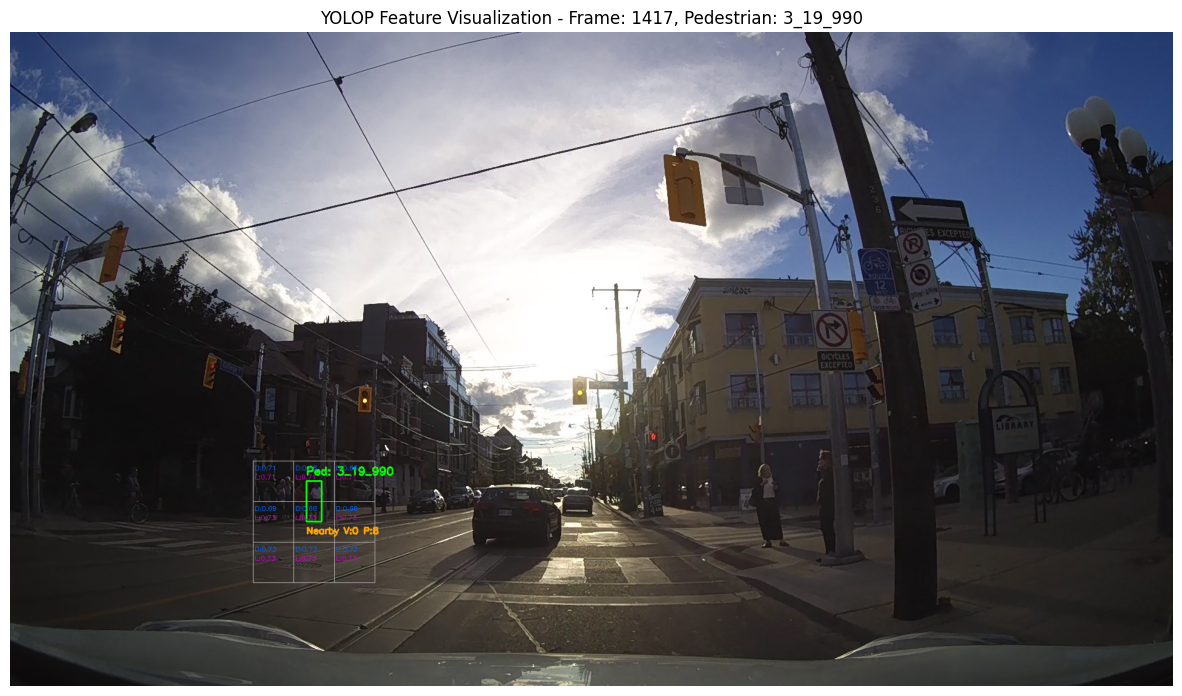

   - Visualizing Frame: 10898, Pedestrian: 3_19_1000


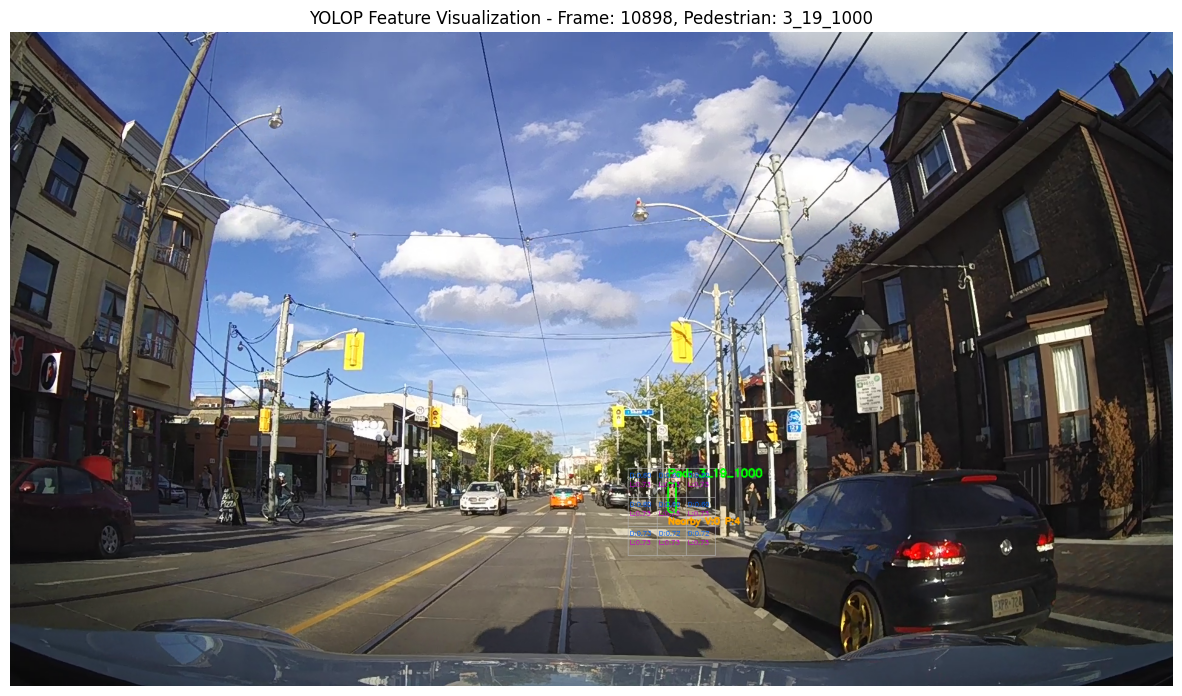

   - Visualizing Frame: 7706, Pedestrian: 3_19_994


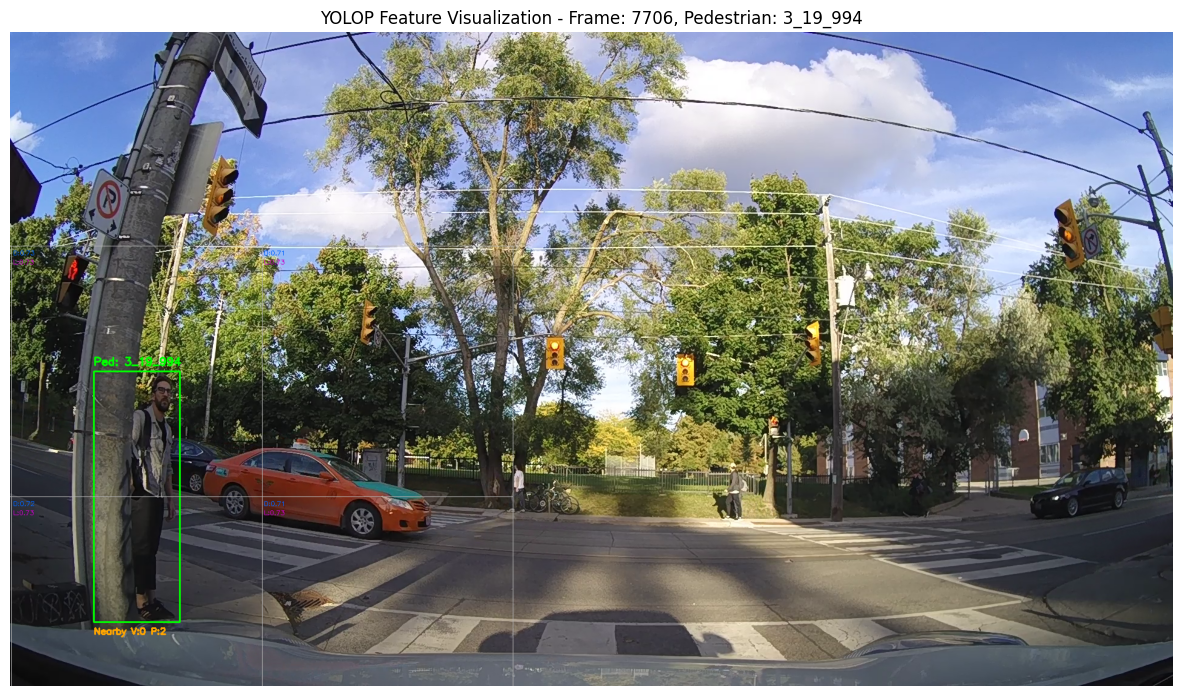

   - Visualizing Frame: 10920, Pedestrian: 3_19_1000


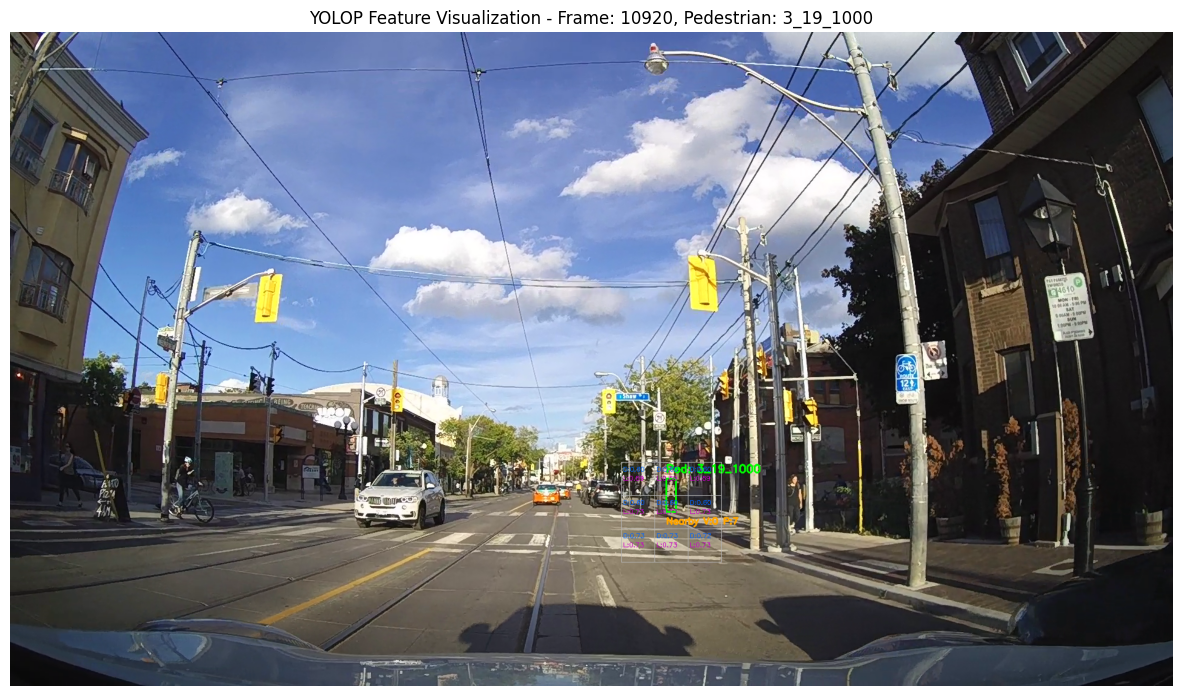

   - Visualizing Frame: 8079, Pedestrian: 3_19_996


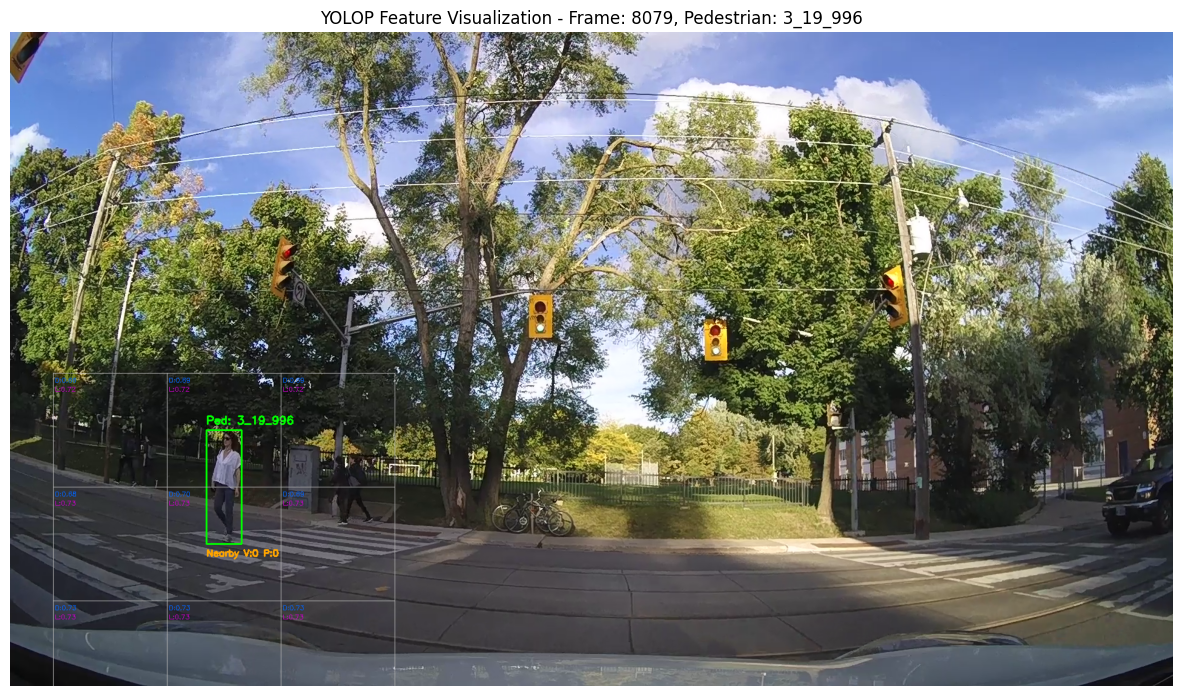


--- Visualization Script Finished ---


In [1]:
# # --- Script to Verify YOLOP Feature PKL File & Visualize from Video ---

# import os
# import pickle
# import numpy as np
# from tqdm.notebook import tqdm
# import random
# import cv2 # Needed for drawing and video reading
# import matplotlib.pyplot as plt # Needed for displaying
# import xml.etree.ElementTree as ET # Need ET here

# # --- Configuration ---
# SET_ID_TO_VERIFY = 'set03'
# VIDEO_ID_TO_VERIFY = 'video_0019' # Example
# OUTPUT_PKL_DIR = '/kaggle/working/extracted_yolop_only' # Where individual PKLs were saved
# ANNOTATION_DIR = '/kaggle/working/PIE/annotations/annotations' # Where setXX annotation XML folders are (*_annt.xml)
# # --- Path to the source VIDEO file ---
# BASE_VIDEO_INPUT_DIR = '/kaggle/input' # Base for video datasets (pie-setXX)
# video_set_input_dir_name = f"pie-{SET_ID_TO_VERIFY}"
# video_set_input_path = os.path.join(BASE_VIDEO_INPUT_DIR, video_set_input_dir_name)
# VIDEO_PATH = os.path.join(video_set_input_path, f"{VIDEO_ID_TO_VERIFY}.mp4")
# # ---

# # Feature Engineering Parameters (MUST match extraction script)
# GRID_SIZE = 3
# GRID_CELL_SIZE_FACTOR = 1.0
# YOLOP_DRIVABLE_FEATURES_DIM = GRID_SIZE * GRID_SIZE # 9
# YOLOP_LANE_FEATURES_DIM = GRID_SIZE * GRID_SIZE # 9
# YOLOP_OBJECT_FEATURES_DIM = 2 # 1 for vehicle count, 1 for ped count
# EXPECTED_FEATURE_DIM = YOLOP_DRIVABLE_FEATURES_DIM + YOLOP_LANE_FEATURES_DIM + YOLOP_OBJECT_FEATURES_DIM # 20

# # Construct paths for PKL and Annotation XML
# unique_video_key = f"{SET_ID_TO_VERIFY}_{VIDEO_ID_TO_VERIFY}"
# pkl_filename = f"{unique_video_key}_yolop_features.pkl"
# PKL_FILE_PATH = os.path.join(OUTPUT_PKL_DIR, pkl_filename)
# ANNOTATION_XML_PATH = os.path.join(ANNOTATION_DIR, SET_ID_TO_VERIFY, f"{VIDEO_ID_TO_VERIFY}_annt.xml")
# # ---

# # --- Verification Parameters ---
# EXPECTED_DTYPE = np.float32
# VALUE_MIN_EXPECTED = 0.0
# VALUE_MAX_EXPECTED = 1.0
# NUM_VISUALIZATIONS = 5 # How many random frames/peds to visualize

# print(f"--- Verifying & Visualizing YOLOP Feature PKL File ---")
# print(f"Verifying Set: {SET_ID_TO_VERIFY}, Video: {VIDEO_ID_TO_VERIFY}")
# print(f"PKL Path: {PKL_FILE_PATH}")
# print(f"Annotation XML Path: {ANNOTATION_XML_PATH}")
# print(f"Source Video Path: {VIDEO_PATH}")
# print(f"Expected Feature Dimension: {EXPECTED_FEATURE_DIM}")

# # --- Helper Function to get BBox from XML ---
# def get_bbox_from_xml(xml_file, target_frame, target_ped_id):
#     # ... (implementation remains the same) ...
#     try: tree = ET.parse(xml_file); root = tree.getroot()
#     except (ET.ParseError, FileNotFoundError) as e: print(f"Error parsing XML {xml_file}: {e}"); return None, None
#     img_width, img_height = None, None
#     try: size_elem = root.find('.//original_size'); img_width = int(size_elem.find('width').text); img_height = int(size_elem.find('height').text)
#     except Exception: pass
#     target_bbox = None
#     for track in root.findall('.//track[@label="pedestrian"]'):
#         for box in track.findall('.//box'):
#             if box.get('frame') == str(target_frame):
#                 id_attribute = box.find(f'.//attribute[@name="id"]')
#                 if id_attribute is not None and id_attribute.text == target_ped_id:
#                     try: xtl, ytl, xbr, ybr = float(box.get('xtl')), float(box.get('ytl')), float(box.get('xbr')), float(box.get('ybr')); target_bbox = [xtl, ytl, xbr, ybr]; return target_bbox, (img_width, img_height)
#                     except Exception as e: print(f"Warn: Error parsing bbox F:{target_frame} P:{target_ped_id} - {e}"); return None, (img_width, img_height)
#     if target_bbox is None: print(f"Warn: Annot box not found F:{target_frame} P:{target_ped_id}")
#     return target_bbox, (img_width, img_height)

# # --- 1. Load the PKL File ---
# print(f"\n[1] Loading PKL file...")
# if not os.path.exists(PKL_FILE_PATH): raise FileNotFoundError(f"PKL file not found: {PKL_FILE_PATH}")
# try:
#     with open(PKL_FILE_PATH, 'rb') as f: loaded_data = pickle.load(f)
#     print(" -> PKL file loaded successfully.")
# except Exception as e: raise IOError(f"Error loading PKL file: {e}")

# # --- 2. Basic Structure Check (Simplified) ---
# print(f"\n[2] Checking Data Structure...")
# if not isinstance(loaded_data, dict) or unique_video_key not in loaded_data or not isinstance(loaded_data[unique_video_key], dict):
#     raise TypeError(f"PKL structure invalid. Expected dict['{unique_video_key}']: dict")
# video_yolop_features = loaded_data[unique_video_key]
# print(f" -> Found data for {len(video_yolop_features)} frames.")

# # --- 3. Gather Samples for Visualization ---
# print(f"\n[3] Gathering samples for visualization...")
# valid_samples_for_vis = []
# for frame_num, frame_data in video_yolop_features.items():
#     for ped_id, feature_vector in frame_data.items():
#          if isinstance(feature_vector, np.ndarray) and feature_vector.shape == (EXPECTED_FEATURE_DIM,):
#              valid_samples_for_vis.append((frame_num, ped_id))

# if not valid_samples_for_vis:
#     print("ERROR: No valid feature vectors found in the PKL file to visualize.")
#     exit()
# print(f" -> Found {len(valid_samples_for_vis)} valid pedestrian feature instances.")

# # --- 4. Visualization from Video ---
# num_to_show = min(NUM_VISUALIZATIONS, len(valid_samples_for_vis))
# print(f"\n[4] Visualizing {num_to_show} Random Samples from Video...")

# # Check video and annotation file existence
# if not os.path.exists(VIDEO_PATH):
#     print(f"ERROR: Video file not found at {VIDEO_PATH}. Cannot visualize.")
#     exit()
# if not os.path.exists(ANNOTATION_XML_PATH):
#      print(f"ERROR: Annotation XML not found at {ANNOTATION_XML_PATH}. Cannot get bboxes.")
#      exit()

# # Open video capture object ONCE
# cap_vis = cv2.VideoCapture(VIDEO_PATH)
# if not cap_vis.isOpened():
#     print(f"ERROR: Could not open video file {VIDEO_PATH}")
#     exit()

# # Get video properties
# vid_width = int(cap_vis.get(cv2.CAP_PROP_FRAME_WIDTH))
# vid_height = int(cap_vis.get(cv2.CAP_PROP_FRAME_HEIGHT))
# total_frames_video = int(cap_vis.get(cv2.CAP_PROP_FRAME_COUNT))
# print(f" -> Video dimensions: {vid_width}x{vid_height}, Total Frames: {total_frames_video}")
# if not (vid_width > 0 and vid_height > 0):
#      print("ERROR: Invalid video dimensions obtained.")
#      cap_vis.release()
#      exit()

# # Select random samples
# samples_to_visualize = random.sample(valid_samples_for_vis, num_to_show)

# for frame_num_vis, ped_id_vis in samples_to_visualize:
#     print(f"   - Visualizing Frame: {frame_num_vis}, Pedestrian: {ped_id_vis}")

#     # --- Read the specific frame from VIDEO ---
#     frame_idx_cv = frame_num_vis - 1 # Convert 1-based frame num to 0-based index
#     if not (0 <= frame_idx_cv < total_frames_video):
#          print(f"     Warning: Frame number {frame_num_vis} (index {frame_idx_cv}) is out of video bounds. Skipping.")
#          continue

#     cap_vis.set(cv2.CAP_PROP_POS_FRAMES, frame_idx_cv) # Seek to the frame
#     ret_vis, frame_vis = cap_vis.read()
#     # --- End Frame Reading ---

#     if not ret_vis:
#         print(f"     Error reading frame {frame_num_vis} (index {frame_idx_cv}) from video.")
#         continue

#     # --- Get Annotation BBox ---
#     bbox_vis, _ = get_bbox_from_xml(ANNOTATION_XML_PATH, frame_num_vis, ped_id_vis)
#     if bbox_vis is None:
#         print(f"     Warning: Could not get annotation bbox for P:{ped_id_vis} F:{frame_num_vis}. Skipping vis.")
#         continue
#     try:
#         x1, y1, x2, y2 = map(int, bbox_vis)
#         ped_cx = int((x1 + x2) / 2)
#         ped_cy = int(y2) # Use bottom-center
#         ped_h_pix = int(y2 - y1)
#         if ped_h_pix <= 0: continue
#     except ValueError:
#         print(f"     Warning: Invalid bbox coords {bbox_vis}. Skipping vis.")
#         continue

#     # --- Get YOLOP Feature Vector ---
#     feature_vector_vis = video_yolop_features[frame_num_vis][ped_id_vis]

#     # --- Draw on a copy ---
#     vis_img = frame_vis.copy()

#     # Draw annotation box (Green)
#     cv2.rectangle(vis_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
#     cv2.putText(vis_img, f"Ped: {ped_id_vis}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

#     # --- Deconstruct Feature Vector and Draw Grid/Counts ---
#     try:
#         da_features = feature_vector_vis[0 : YOLOP_DRIVABLE_FEATURES_DIM]
#         ll_features = feature_vector_vis[YOLOP_DRIVABLE_FEATURES_DIM : YOLOP_DRIVABLE_FEATURES_DIM + YOLOP_LANE_FEATURES_DIM]
#         obj_features = feature_vector_vis[YOLOP_DRIVABLE_FEATURES_DIM + YOLOP_LANE_FEATURES_DIM : ]

#         da_grid = da_features.reshape((GRID_SIZE, GRID_SIZE))
#         ll_grid = ll_features.reshape((GRID_SIZE, GRID_SIZE))

#         grid_cell_pixel_size = max(1, int(ped_h_pix * GRID_CELL_SIZE_FACTOR))
#         half_grid_total_size = (GRID_SIZE * grid_cell_pixel_size) // 2
#         grid_x_start = ped_cx - half_grid_total_size
#         grid_y_start = ped_cy - half_grid_total_size

#         for r in range(GRID_SIZE):
#             for c in range(GRID_SIZE):
#                 cell_x1 = grid_x_start + c * grid_cell_pixel_size
#                 cell_y1 = grid_y_start + r * grid_cell_pixel_size
#                 cell_x2 = cell_x1 + grid_cell_pixel_size
#                 cell_y2 = cell_y1 + grid_cell_pixel_size
#                 cv2.rectangle(vis_img, (cell_x1, cell_y1), (cell_x2, cell_y2), (180, 180, 180), 1)
#                 da_val_str = f"D:{da_grid[r, c]:.2f}"
#                 cv2.putText(vis_img, da_val_str, (cell_x1 + 3, cell_y1 + 15), cv2.FONT_HERSHEY_SIMPLEX, 0.35, (255, 100, 0), 1)
#                 ll_val_str = f"L:{ll_grid[r, c]:.2f}"
#                 cv2.putText(vis_img, ll_val_str, (cell_x1 + 3, cell_y1 + 30), cv2.FONT_HERSHEY_SIMPLEX, 0.35, (200, 0, 200), 1)

#         max_count = 10.0 # Make sure this matches extraction
#         veh_count = int(round(obj_features[0] * max_count))
#         ped_count = int(round(obj_features[1] * max_count))
#         count_text = f"Nearby V:{veh_count} P:{ped_count}"
#         cv2.putText(vis_img, count_text, (x1, y2 + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 165, 255), 2) # Orange

#     except Exception as e:
#         print(f"     Warning: Error drawing features for P:{ped_id_vis} F:{frame_num_vis} - {e}")

#     # --- Display using matplotlib ---
#     plt.figure(figsize=(15, 9))
#     plt.imshow(cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB))
#     plt.title(f"YOLOP Feature Visualization - Frame: {frame_num_vis}, Pedestrian: {ped_id_vis}")
#     plt.axis('off')
#     plt.show()

# # Release video capture object AFTER the loop
# cap_vis.release()
# print("\n--- Visualization Script Finished ---")